# 4. 决策树 Part II

## 4.3. scikit-learn决策树算法类库介绍

scikit-learn决策树算法类库内部实现是使用了调优过的CART树算法，既可以做分类，又可以做回归。分类决策树的类对应的是DecisionTreeClassifier，而回归决策树的类对应的是DecisionTreeRegressor。两者的参数定义几乎完全相同，但是意义不全相同。下面就对DecisionTreeClassifier和DecisionTreeRegressor的重要参数做一个总结，重点比较两者参数使用的不同点和调参的注意点。

### 4.3.1. DecisionTreeClassifier和DecisionTreeClassifier 重要参数调参注意点

特征选择标准criterion

 - DecisionTreeClassifier

    -- 可以使用"gini"或者"entropy"，前者代表基尼系数，后者代表信息增益。一般说使用默认的基尼系数"gini"就可以了，即CART算法。除非你更喜欢类似ID3, C4.5的最优特征选择方法。

 - DecisionTreeRegressor

    -- 可以使用"mse"或者"mae"，前者是均方差，后者是和均值之差的绝对值之和。推荐使用默认的"mse"。一般来说"mse"比"mae"更加精确。除非你想比较二个参数的效果的不同之处。

特征划分点选择标准splitter

 - 可以使用"best"或者"random"。前者在特征的所有划分点中找出最优的划分点。后者是随机的在部分划分点中找局部最优的划分点。

 - 默认的"best"适合样本量不大的时候，而如果样本数据量非常大，此时决策树构建推荐"random" 

划分时考虑的最大特征数max_features

 - 可以使用很多种类型的值，默认是"None",意味着划分时考虑所有的特征数；如果是"log2"意味着划分时最多考虑log2N

决策树最大深max_depth

 - 决策树的最大深度，默认可以不输入，如果不输入的话，决策树在建立子树的时候不会限制子树的深度。一般来说，数据少或者特征少的时候可以不管这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值10-100之间。
 
 

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


## 4.5 正则化超参数

决策树几乎不对训练数据做任何假设（于此相反的是线性回归等模型，这类模型通常会假设数据是符合线性关系的）。

如果不添加约束，树结构模型通常将根据训练数据调整自己，使自身能够很好的拟合数据，而这种情况下大多数会导致模型过拟合。

这一类的模型通常会被称为非参数模型，这不是因为它没有任何参数（通常也有很多），而是因为在训练之前没有确定参数的具体数量，所以模型结构可以根据数据的特性自由生长。

于此相反的是，像线性回归这样的参数模型有事先设定好的参数数量，所以自由度是受限的，这就减少了过拟合的风险（但是增加了欠拟合的风险）。

`DecisionTreeClassifier`类还有一些其他的参数用于限制树模型的形状:

> 1. `min_samples_split`（节点在被分裂之前必须具有的最小样本数），
> 2. `min_samples_leaf`（叶节点必须具有的最小样本数），
> 3. `min_weight_fraction_leaf`（和`min_samples_leaf`相同，但表示为加权总数的一小部分实例），
> 4. `max_leaf_nodes`（叶节点的最大数量）`和max_features`（在每个节点被评估是否分裂的时候，具有的最大特征数量）。
> 5. 增加`min_* hyperparameters`或者减少`max_* hyperparameters`会使模型正则化。


> 一些其他算法的工作原理是在没有任何约束条件下训练决策树模型，让模型自由生长，然后再对不需要的节点进行剪枝。
>
> 当一个节点的全部子节点都是叶节点时，如果它对纯度的提升不具有统计学意义，我们就认为这个分支是不必要的。
>
> 标准的假设检验，例如卡方检测，通常会被用于评估一个概率值 -- 即改进是否纯粹是偶然性的结果（也叫原假设）
>
> 如果 p 值比给定的阈值更高（通常设定为 5%，也就是 95% 置信度，通过超参数设置），那么节点就被认为是非必要的，它的子节点会被删除。
>
> 这种剪枝方式将会一直进行，直到所有的非必要节点都被删光。

In [2]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)


C:\Users\zhuyi\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # This is added back by InteractiveShellApp.init_path()
C:\Users\zhuyi\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # This is added back by InteractiveShellApp.init_path()


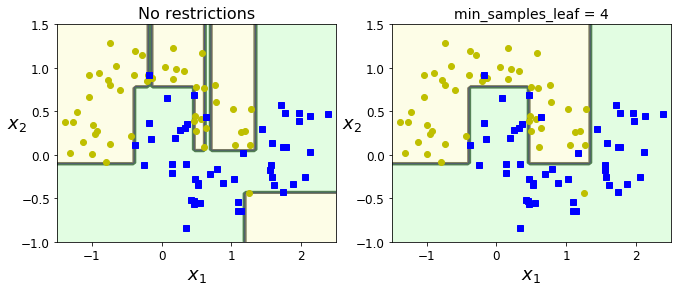

In [3]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

#save_fig("min_samples_leaf_plot")
plt.show()

4.5.1 剪枝参数

在不加限制的情况下，一棵决策树会生长到衡量不纯度的指标最优，或者没有更多的特征可用为止。这样的决策树往往会过拟合，这就是说，它会在训练集上表现很好，在测试集上却表现糟糕。我们收集的样本数据不可能和整体 的状况完全一致，因此当一棵决策树对训练数据有了过于优秀的解释性，它找出的规则必然包含了训练样本中的噪 声，并使它对未知数据的拟合程度不足。

为了让决策树有更好的泛化性，我们要对决策树进行剪枝。剪枝策略对决策树的影响巨大，正确的剪枝策略是优化决策树算法的核心。sklearn为我们提供了不同的剪枝策略：

 1. max_depth
    > * 限制树的最大深度，超过设定深度的树枝全部剪掉
    > * 这是用得最广泛的剪枝参数，在高维度低样本量时非常有效。决策树多生长一层，对样本量的需求会增加一倍，所以限制树深度能够有效地限制过拟合。在集成算法中也非常实用。实际使用时，建议从=3开始尝试，看看拟合的效 果再决定是否增加设定深度。
    
 2. min_samples_leaf & min_samples_split
    > * min_samples_leaf限定，一个节点在分枝后的每个子节点都必须包含至少min_samples_leaf个训练样本，否则分枝就不会发生，或者，分枝会朝着满足每个子节点都包含min_samples_leaf个样本的方向去发生.
    > * 一般搭配max_depth使用，在回归树中有神奇的效果，可以让模型变得更加平滑。这个参数的数量设置得太小会引起过拟合，设置得太大就会阻止模型学习数据。一般来说，建议从=5开始使用。如果叶节点中含有的样本量变化很 大，建议输入浮点数作为样本量的百分比来使用。同时，这个参数可以保证每个叶子的最小尺寸，可以在回归问题 中避免低方差，过拟合的叶子节点出现。对于类别不多的分类问题，=1通常就是最佳选择。
    > * min_samples_split限定，一个节点必须要包含至少min_samples_split个训练样本，这个节点才允许被分枝，否则分枝就不会发生。
 

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [5]:
iris = load_iris()

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=0)

In [6]:
clf = DecisionTreeClassifier(criterion="entropy",
                             random_state=1234,
                             splitter="random",
                             max_depth=7,
                             min_samples_leaf=1,
                             min_samples_split=2
                             )
clf = clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.9666666666666667

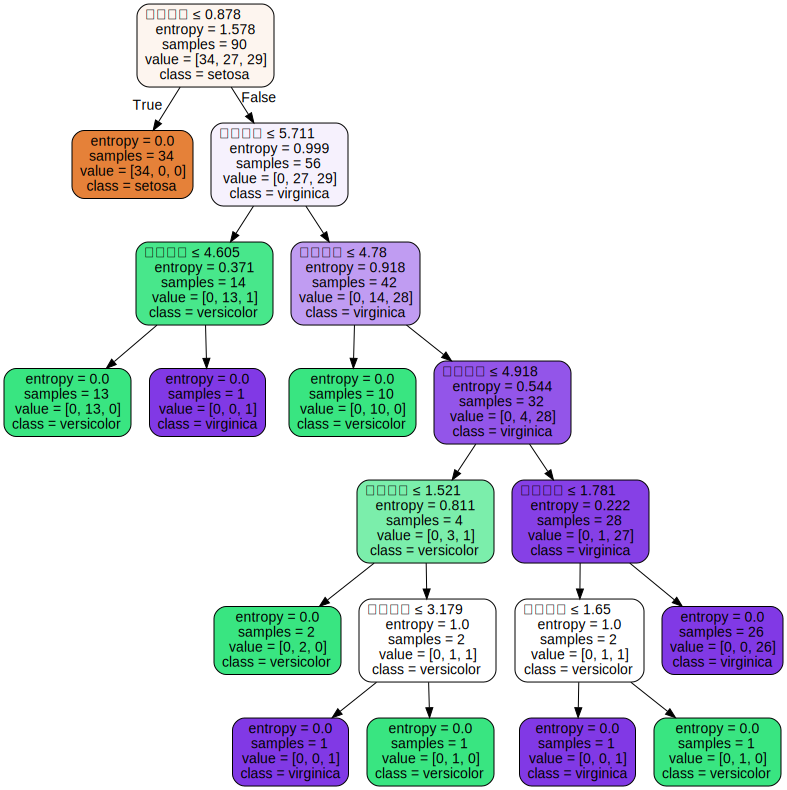

In [7]:
from sklearn.tree import export_graphviz 
import graphviz

feature_names = ["花萼长度","花萼宽度","花瓣长度","花瓣宽度"]
dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         class_names=iris.target_names,  
                         filled=True, 
                         rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

确认最优的剪枝参数

那具体怎么来确定每个参数填写什么值呢？这时候，我们就要使用确定超参数的曲线来进行判断了，继续使用我们
已经训练好的决策树模型clf。超参数的学习曲线，是一条以超参数的取值为横坐标，模型的度量指标为纵坐标的曲 线，它是用来衡量不同超参数取值下模型的表现的线。在我们建好的决策树里，我们的模型度量指标就是score。

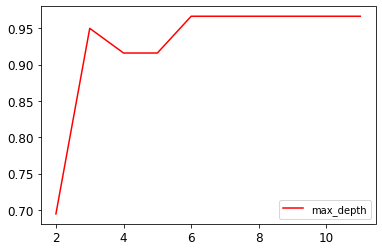

In [8]:
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

test = []
for i in range(10):
    tree_clf = DecisionTreeClassifier(max_depth=i+2,
                                 criterion="entropy",
                                 random_state=1234,
                                 splitter="random",
                                )
    tree_clf.fit(X_train, y_train)
    y_pred = tree_clf.predict(X_test)
    score = metrics.f1_score(y_test,y_pred, average='weighted')
    test.append(score)
plt.plot(range(2,12),test,color="red",label="max_depth")
plt.legend()
plt.show()

## 回归

决策树也能够执行回归任务，让我们使用 Scikit-Learn 的`DecisionTreeRegressor`类构建一个回归树，让我们用`max_depth = 2`在具有噪声的二次项数据集上进行训练。


In [9]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

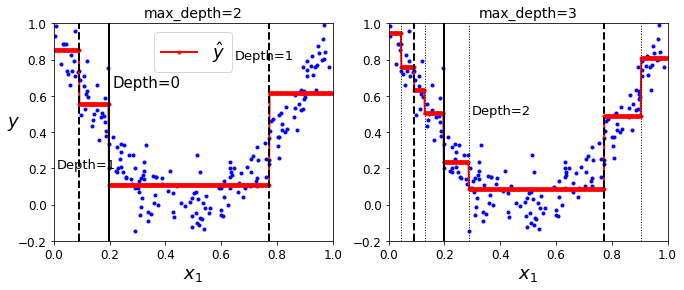

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

#save_fig("tree_regression_plot")
plt.show()

这棵树看起来非常类似于你之前建立的分类树，它的主要区别在于，它不是预测每个节点中的样本所属的分类，而是预测一个具体的数值。例如，假设您想对 $ x_1 = 0.6 $ 的新实例进行预测。从根开始遍历树，最终到达预测值等于 0.1106 的叶节点。该预测仅仅是与该叶节点相关的 110 个训练实例的平均目标值。而这个预测结果在对应的 110 个实例上的均方误差（MSE）等于 0.0151。

在图 6-5 的左侧显示的是模型的预测结果，如果你将`max_depth=3`设置为 3，模型就会如 6-5 图右侧显示的那样.注意每个区域的预测值总是该区域中实例的平均目标值。算法以一种使大多数训练实例尽可能接近该预测值的方式分割每个区域。

CART 算法的工作方式与之前处理分类模型基本一样，不同之处在于，现在不再以最小化不纯度的方式分割训练集，而是试图以最小化 MSE 的方式分割训练集。 


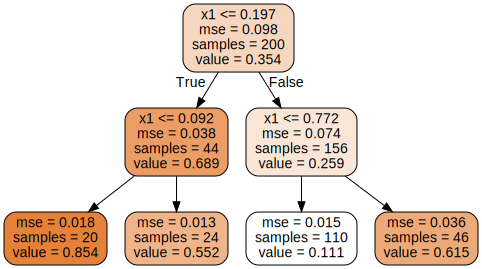

In [13]:
dot_data = export_graphviz(tree_reg1, out_file=None, 
                         feature_names=["x1"],  
                         filled=True, 
                         rounded=True,  
                         )  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png()) 
graph = graphviz.Source(dot_data) 
graph

和处理分类任务时一样，决策树在处理回归问题的时候也容易过拟合。如果不添加任何正则化（默认的超参数），你就会得到图 6-6 左侧的预测结果，显然，过度拟合的程度非常严重。而当我们设置了`min_samples_leaf = 10`，相对就会产生一个更加合适的模型了，就如图 6-6 所示的那样。

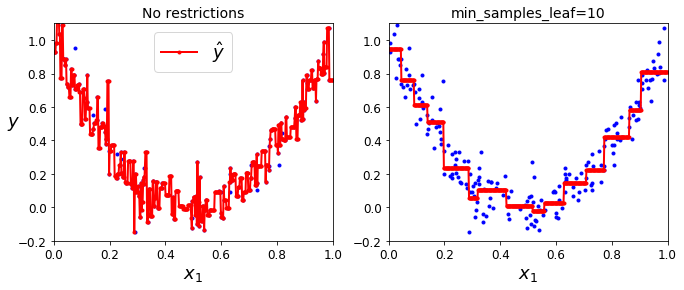

In [14]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

#save_fig("tree_regression_regularization_plot")
plt.show()